In [21]:
import pandas as pd

df = pd.read_csv('dados_arduino_2.csv', encoding='ISO-8859-1')
df = df.head(80)
display(df)

,Tempo_µs,Ciclo_CPU,Referencia_Motor,Vel_Real
0,84032.0,136.0,2706.0,0.0
1,87072.0,136.0,2706.0,0.0
2,91216.0,136.0,2706.0,0.0
3,95360.0,136.0,2706.0,0.0
4,110680.0,136.0,2706.0,0.0
...,...,...,...,...
75,1677340.0,192.0,2989.0,1339.0
76,1700932.0,192.0,2881.0,750.0
77,1724516.0,192.0,2930.0,750.0
78,1747116.0,192.0,2972.0,803.0


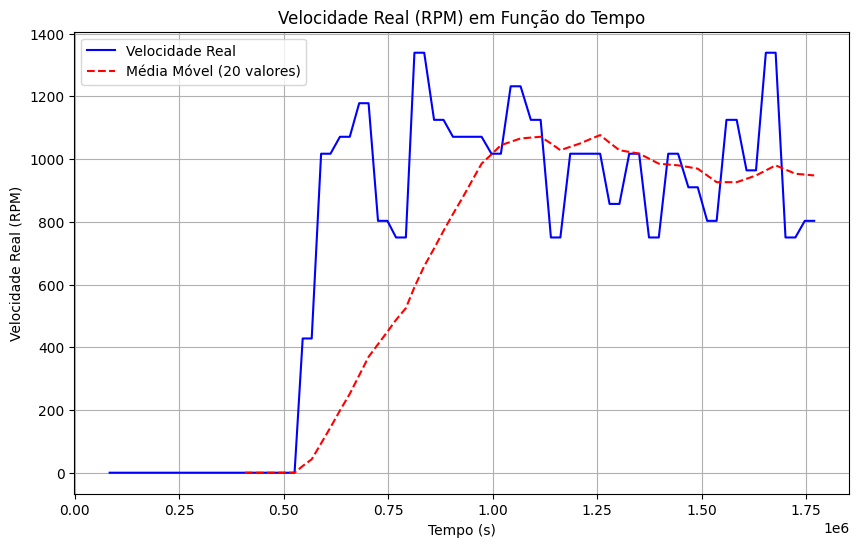

In [22]:
import matplotlib.pyplot as plt

# Calcular a média móvel de 10 valores
df['Vel_Real_Media'] = df['Vel_Real'].rolling(window=20).mean()

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Tamanho da figura
plt.plot(df['Tempo_µs'], df['Vel_Real'], label='Velocidade Real', color='b')  # Gráfico original
plt.plot(df['Tempo_µs'], df['Vel_Real_Media'], label='Média Móvel (20 valores)', color='r', linestyle='--')  # Gráfico da média móvel

# Adicionar título e rótulos aos eixos
plt.title('Velocidade Real (RPM) em Função do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade Real (RPM)')

# Mostrar a legenda
plt.legend()

# Mostrar o gráfico
plt.grid(True)  # Adicionar uma grade ao gráfico
plt.show()